In [1]:
import torch, random, math, os, time
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchio as tio
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\PC00\anaconda3\envs\MR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(42)

In [3]:
tio_transform = [tio.ToCanonical(),
                 tio.transforms.RescaleIntensity(),
                 tio.Resample((1,1,1))]

ixi_dataset = tio.datasets.IXI("path/to/ixi_root",
                               modalities=('T2', 'PD'),
                               transform=tio.Compose(tio_transform),
                               download=False)

print(len(ixi_dataset))

578


In [4]:
CFG={"IM_SIZE": 256,
     "UNDERSAMPLE_RATE": 3,
     "Num_Echoes": 8,
     "Lambda_data": 0.2,
     "Lambda_CNN": 1.0,
     "LR": 0.0005,
     "EPOCHS": 200}

In [5]:
model_root = "E:/model_save_path/Parameter_mapping/MANTIS/"

prev_try_num = 5
additive_train = False

curr_try_num = 6

model_prev_path = f"{model_root}{prev_try_num}.pt"
model_curr_path = f"{model_root}{curr_try_num}.pt"

In [6]:
class IXI_Dataset(Dataset):
    def __init__(self, total_data, resize=True):
        self.total_data = total_data
        self.resize = resize
    
    def __len__(self):
        return len(self.total_data)
    
    def __get_multiecho__(self, I0, T2):
        TEs = [7, 16, 25, 34, 43, 52, 62, 71]  # milli-sec (from MANTIS paper)
        return [I0 * torch.exp(-1e-3*x/T2) for x in TEs]
    
    def __concat__(self, I0, T2):
        output = None
        images = self.__get_multiecho__(I0, T2)
        for im in images:
            tensor = im.unsqueeze(0)
            if output is None:
                output = tensor
            else:
                output = torch.concatenate((output, tensor), dim=0)
        
        return output
    
    # def __1D_variable_masks__(self, center_fraction=0.1, power=2.0, R=2, num_echoes=8):
    #     num_center = int(CFG["IM_SIZE"] * center_fraction)
    #     center_start = (CFG["IM_SIZE"] - num_center) // 2
    #     center_end = center_start + num_center

    #     x = np.linspace(-1, 1, CFG["IM_SIZE"])
    #     density_prob = (1 - np.abs(x)) ** power

    #     total_mask = np.zeros((num_echoes, CFG["IM_SIZE"], CFG["IM_SIZE"]))
    #     for echo in range(num_echoes):
    #         mask = np.random.rand(CFG["IM_SIZE"]) < density_prob
    #         mask[center_start:center_end] = 1

    #         while mask.sum() > CFG["IM_SIZE"] / R:
    #             mask[np.random.choice(np.where(mask == 1)[0])] = 0
            
    #         echo_mask = np.zeros((CFG["IM_SIZE"], CFG["IM_SIZE"]))
    #         for i in mask:
    #             echo_mask[:, i] = np.ones(CFG["IM_SIZE"]) * mask[i]
    #         total_mask[echo] = echo_mask

    #     return torch.from_numpy(total_mask)
    
    def __1D_variable_density_mask__(self, center_fraction, under_rate):
        center_size = int(CFG["IM_SIZE"] * center_fraction)
        center_start = (CFG["IM_SIZE"] - center_size) // 2
        center_end = center_start + center_size

        total_masks = np.empty((CFG["Num_Echoes"], CFG["IM_SIZE"], CFG["IM_SIZE"]))
        x = np.arange(0, CFG["IM_SIZE"])

        for echo in range(CFG["Num_Echoes"]):
            echo_mask = np.zeros((CFG["IM_SIZE"], CFG["IM_SIZE"]))
            echo_mask[:, center_start:center_end] = 1
            large_samples = np.random.normal(np.mean(x), np.std(x), 1000).astype(int)
            selected = set()
            for sample in large_samples:
                if 0 <= sample < CFG["IM_SIZE"]: selected.add(sample)
                if len(selected) == (CFG["IM_SIZE"] // under_rate - center_size): break
            for col in selected:
                echo_mask[:, col] = 1
            total_masks[echo] = echo_mask
        
        return torch.from_numpy(total_masks)
        
    def __undersampling__(self, echo_images, masks):
        undersampled_real, undersampled_imag = torch.empty_like(echo_images), torch.empty_like(echo_images)
        undersampled_echo_images = torch.empty_like(echo_images)
        for echo in range(CFG["Num_Echoes"]):
            curr_echo_im = echo_images[echo]
            curr_echo_kspace = torch.fft.fftshift(torch.fft.fft2(curr_echo_im.to(torch.complex64), norm="ortho")) # Fully-sampled
            real_masked, imag_masked = curr_echo_kspace.real * masks[echo], curr_echo_kspace.imag * masks[echo]
            undersampled_real[echo] = real_masked
            undersampled_imag[echo] = imag_masked
            curr_dj = torch.view_as_complex(torch.stack((real_masked, imag_masked), dim=-1))
            undersampled_echo_images[echo] = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(curr_dj), norm="ortho"))
        undersampled_kspace = torch.view_as_complex(torch.stack((undersampled_real, undersampled_imag), dim=-1))
        return undersampled_kspace, undersampled_echo_images
    
    def __getitem__(self, index):
        subject = self.total_data[index]
        ref_I0 = subject['PD'].data[0][:, :, 80]
        ref_T2 = subject['T2'].data[0][:, :, 80]
        if self.resize == True:
            resize = transforms.Resize((CFG["IM_SIZE"], CFG["IM_SIZE"]))
            ref_I0 = resize(ref_I0.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            ref_T2 = resize(ref_T2.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        multiecho_images = self.__concat__(ref_I0, ref_T2)  # (8, 256, 256)
        echo_masks = self.__1D_variable_density_mask__(center_fraction=0.1, under_rate=3)
        ref_kspace, i_u = self.__undersampling__(multiecho_images, echo_masks)
        return i_u.to(torch.float32), ref_I0.to(torch.float32), ref_T2.to(torch.float32), ref_kspace, echo_masks.to(torch.float32) # GPU 연산에 float64(double)이나 int형은 비효율적

In [7]:
total_dataset = IXI_Dataset(ixi_dataset, resize=True)
train_dataset, test_dataset = random_split(total_dataset, [500, 78])
train_loader, test_loader = DataLoader(train_dataset, 1), DataLoader(test_dataset, 1)
print(len(train_dataset), len(test_dataset))

500 78


torch.Size([1, 8, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 8, 256, 256])


(<Axes: >, <matplotlib.image.AxesImage at 0x19e59176fd0>)

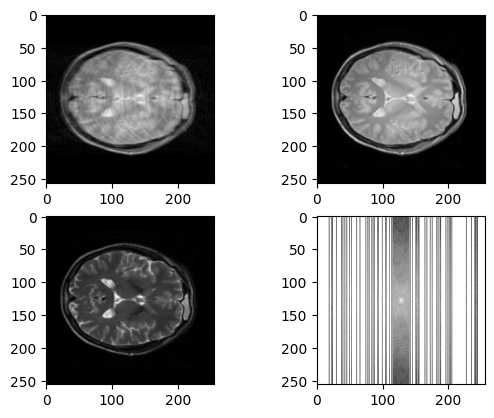

In [8]:
iu, I0, T2, dj, masks = next(iter(train_loader))
print(iu.shape, I0.shape, T2.shape, dj.shape)
plt.subplot(221), plt.imshow(iu[0][0], cmap='gray')
plt.subplot(222), plt.imshow(I0[0], cmap='gray')
plt.subplot(223), plt.imshow(T2[0], cmap='gray')
plt.subplot(224), plt.imshow(torch.log(torch.abs(dj[0][0])), cmap='gray')

In [8]:
class brown_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(brown_block, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    
class contracting_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(contracting_block, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.conv(x)
        x = self.bn(x)
        return x

class expanding_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(expanding_block, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.deconv(x)
        x = self.bn(x)
        return x

class blue_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(blue_block, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.deconv(x)
        x = self.relu(x)
        return x

In [9]:
class MANTIS(nn.Module):
    def __init__(self):
        super(MANTIS, self).__init__()
        self.fusion = brown_block(8, 64)

        self.encoder1 = contracting_block(64, 128)
        self.encoder2 = contracting_block(128, 256)
        self.encoder3 = contracting_block(256, 512)
        self.encoder4 = contracting_block(512, 512)
        self.encoder5 = nn.Sequential(contracting_block(512, 512), contracting_block(512, 512)) # block 3개 하면 (1,512,1,1) -> train error (모든 채널 차원이 1이상이어야 함?)

        self.decoder1 = nn.Sequential(expanding_block(512, 512), expanding_block(512, 512))
        self.decoder2 = expanding_block(1024, 512)
        self.decoder3 = expanding_block(1024, 256)
        self.decoder4 = expanding_block(512, 128)
        self.decoder5 = expanding_block(256, 64)

        self.estimation = blue_block(128, 2)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x_fused = self.fusion(x)

        # Encoder path
        x_en1 = self.encoder1(x_fused)
        x_en2 = self.encoder2(x_en1)
        x_en3 = self.encoder3(x_en2)
        x_en4 = self.encoder4(x_en3)
        x_en5 = self.encoder5(x_en4)

        # Decoder path
        x_de1 = self.decoder1(x_en5)
        x_de2 = self.decoder2(torch.cat((x_de1, x_en4), dim=1))
        x_de3 = self.decoder3(torch.cat((x_de2, x_en3), dim=1))
        x_de4 = self.decoder4(torch.cat((x_de3, x_en2), dim=1))
        x_de5 = self.decoder5(torch.cat((x_de4, x_en1), dim=1))

        x = self.estimation(torch.cat((x_de5, x_fused), dim=1))

        return x
    
class Cyclic_loss(nn.Module):
    def __init__(self, lambda_data=0.1, lambda_cnn=1.0):
        super(Cyclic_loss, self).__init__()
        self.lambda_data = lambda_data
        self.lambda_cnn = lambda_cnn
        self.CNN = MANTIS()
        self.mse_loss = nn.MSELoss()
    
    def forward(self, pred_I0, pred_T2, gt_I0, gt_T2, ref_kspace, masks):
        TEs = [7, 16, 25, 34, 43, 52, 62, 71]
        cnn_loss = self.mse_loss(pred_I0, gt_I0) + self.mse_loss(pred_T2, gt_T2)

        pred_I0, pred_T2 = pred_I0.squeeze(0), pred_T2.squeeze(0)
        reconstructed_kspace = [torch.fft.fftshift(torch.fft.fft2( (pred_I0 * torch.exp(-1e-3*TE/pred_T2)).to(torch.complex64), norm="ortho" )) for TE in TEs]
        real_tensor, imag_tensor = torch.zeros((8, CFG["IM_SIZE"], CFG["IM_SIZE"])), torch.zeros((8, CFG["IM_SIZE"], CFG["IM_SIZE"]))
        for ch in range(len(reconstructed_kspace)):
            real_tensor[ch] = reconstructed_kspace[ch].real
            imag_tensor[ch] = reconstructed_kspace[ch].imag
        real_masked, imag_masked = real_tensor.to(device) * masks, imag_tensor.to(device) * masks
        ref_real, ref_imag = ref_kspace.real, ref_kspace.imag
        real_loss = sum(self.mse_loss(real_k, real_masked[idx]) for idx, real_k in enumerate(ref_real))
        imag_loss = sum(self.mse_loss(imag_k, imag_masked[idx]) for idx, imag_k in enumerate(ref_imag))

        return self.lambda_data * (real_loss + imag_loss) + self.lambda_cnn * cnn_loss

In [10]:
model = MANTIS()
model = nn.DataParallel(model)
model.to(device)
loss_fn = Cyclic_loss(lambda_data=CFG["Lambda_data"], lambda_cnn=CFG["Lambda_CNN"]).to(device)
optim = torch.optim.Adam(model.parameters(), lr=CFG["LR"])

In [12]:
if additive_train:
    model.load_state_dict(torch.load(model_prev_path))

In [13]:
model.train()
for epoch in range(200):
    start_time = time.time()
    for i_u, gt_I0, gt_T2, dj, masks in train_loader:
        i_u, gt_I0, gt_T2, dj, masks = i_u.to("cuda"), gt_I0.to("cuda"), gt_T2.to("cuda"), dj.to("cuda"), masks.to("cuda")
        output = model(i_u)
        pred_I0, pred_T2 = output[:, 0, :, :], output[:, 1, :, :]

        loss = loss_fn(pred_I0, pred_T2, gt_I0, gt_T2, dj, masks)

        optim.zero_grad()
        loss.backward()
        optim.step()
    end_time = time.time()
    time_spent = end_time - start_time
    if (epoch%10) == 0:
        print(f"[Epoch{epoch+1}] Loss: {loss.item()}\tSpent {time_spent//60}min {time_spent%60}sec")
torch.save(model.state_dict(), model_curr_path)

[Epoch1] Loss: 0.05769481882452965	Spent 6.0min 34.97297739982605sec
[Epoch11] Loss: 0.002514856867492199	Spent 6.0min 26.750934600830078sec
[Epoch21] Loss: 0.0022424941416829824	Spent 6.0min 4.755423069000244sec
[Epoch31] Loss: 0.0009760211687535048	Spent 6.0min 20.224181175231934sec
[Epoch41] Loss: 0.002456499496474862	Spent 6.0min 10.625311851501465sec
[Epoch51] Loss: 0.001990379299968481	Spent 6.0min 11.646928787231445sec
[Epoch61] Loss: 0.002930861199274659	Spent 6.0min 11.039073944091797sec
[Epoch71] Loss: 0.00393236568197608	Spent 6.0min 11.0447359085083sec
[Epoch81] Loss: 0.002287590876221657	Spent 6.0min 9.486804485321045sec
[Epoch91] Loss: 0.0019955921452492476	Spent 6.0min 9.058954954147339sec
[Epoch101] Loss: 0.002202031435444951	Spent 6.0min 9.644872426986694sec
[Epoch111] Loss: 0.0008923343848437071	Spent 6.0min 10.386807441711426sec
[Epoch121] Loss: 0.0006394992233254015	Spent 6.0min 7.05622673034668sec
[Epoch131] Loss: 0.0005979842389933765	Spent 6.0min 8.65632891654968

In [ ]:
# model.load_state_dict(torch.load(model_curr_path))
# model.eval()
# test_I0, test_T2 = [], []
# for i_u, gt_I0, gt_T2, dj, masks in test_loader:    
#     i_u, gt_I0, gt_T2, dj, masks = i_u.to("cuda"), gt_I0.to("cuda"), gt_T2.to("cuda"), dj.to("cuda"), masks.to("cuda")
#     output = model(i_u)
#     pred_I0, pred_T2 = output[:, 0, :, :], output[:, 1, :, :]

#     test_I0.append(pred_I0)
#     test_T2.append(pred_T2)

In [ ]:
# There are 78 samples in test dataset in total
test_index = 30 # (0~77)

In [ ]:
model_path_1 = f"{model_root}5.pt"

model.load_state_dict(torch.load(model_path_1))
model.eval()

test_sample = test_dataset[test_index]

i_u, gt_I0, gt_T2, dj, masks = test_sample[0].unsqueeze(0).to("cuda"), test_sample[1].unsqueeze(0).to("cuda"), test_sample[2].unsqueeze(0).to("cuda"), test_sample[3].unsqueeze(0).to("cuda"), test_sample[4].unsqueeze(0).to("cuda")
output_1 = model(i_u)
I0_pred_1, T2_pred_1 = output_1[:, 0, :, :], output_1[:, 1, :, :]

In [ ]:
model_path_2 = f"{model_root}6.pt"

model.load_state_dict(torch.load(model_path_2))
model.eval()

test_sample = test_dataset[test_index]

i_u, _, _, _, _ = test_sample[0].unsqueeze(0).to("cuda"), test_sample[1].unsqueeze(0).to("cuda"), test_sample[2].unsqueeze(0).to("cuda"), test_sample[3].unsqueeze(0).to("cuda"), test_sample[4].unsqueeze(0).to("cuda")
output_2 = model(i_u)
I0_pred_2, T2_pred_2 = output_2[:, 0, :, :], output_2[:, 1, :, :]

C:\Users\PC00\AppData\Local\Temp\ipykernel_24380\3439922841.py:4: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122), plt.imshow(np.log(np.abs(test_dj[4])), cmap='gray')


(<Axes: >, <matplotlib.image.AxesImage at 0x12aa2f66d10>)

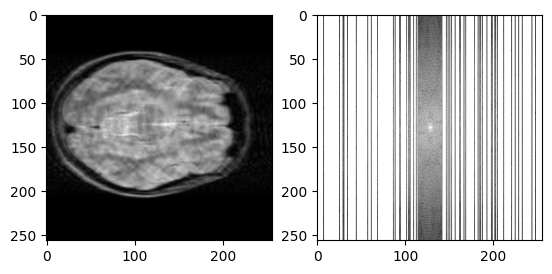

In [36]:
test_iu = i_u[0].detach().cpu().numpy()
test_dj = dj[0].detach().cpu().numpy()
plt.subplot(121), plt.imshow(test_iu[4], cmap='gray')
plt.subplot(122), plt.imshow(np.log(np.abs(test_dj[4])), cmap='gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x12a88e66750>)

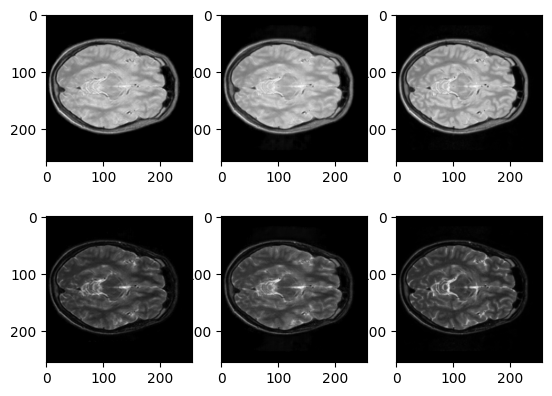

In [37]:
test_sample_gt_I0 = gt_I0[0].detach().cpu().numpy()
test_sample_gt_T2 = gt_T2[0].detach().cpu().numpy()
test_pred_I0_1 = I0_pred_1[0].detach().cpu().numpy()
test_pred_T2_1 = T2_pred_1[0].detach().cpu().numpy()
test_pred_I0_2 = I0_pred_2[0].detach().cpu().numpy()
test_pred_T2_2 = T2_pred_2[0].detach().cpu().numpy()
plt.subplot(231), plt.imshow(test_pred_I0_1, cmap='gray')
plt.subplot(232), plt.imshow(test_pred_I0_2, cmap='gray')
plt.subplot(233), plt.imshow(test_sample_gt_I0, cmap='gray')
plt.subplot(234), plt.imshow(test_pred_T2_1, cmap='gray')
plt.subplot(235), plt.imshow(test_pred_T2_2, cmap='gray')
plt.subplot(236), plt.imshow(test_sample_gt_T2, cmap='gray')

(<Axes: title={'center': 'Pred2-Pred1'}>,
 Text(0.5, 1.0, 'Pred2-Pred1'))

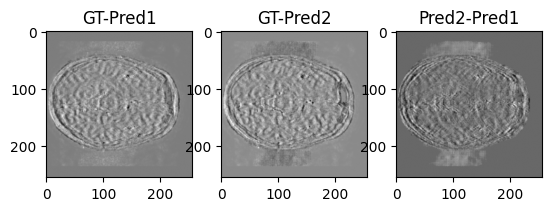

In [39]:
plt.subplot(131), plt.imshow(test_sample_gt_I0-test_pred_I0_1, cmap='gray'), plt.title("GT-Pred1")
plt.subplot(132), plt.imshow(test_sample_gt_I0-test_pred_I0_2, cmap='gray'), plt.title("GT-Pred2")
plt.subplot(133), plt.imshow(test_pred_I0_2-test_pred_I0_1, cmap='gray'), plt.title("Pred2-Pred1")

(<Axes: title={'center': 'Pred2-Pred1'}>,
 Text(0.5, 1.0, 'Pred2-Pred1'))

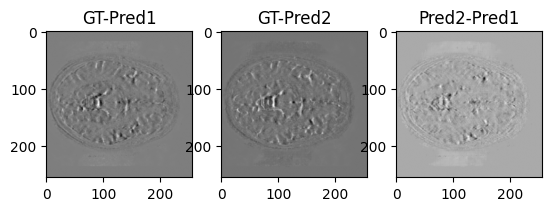

In [41]:
plt.subplot(131), plt.imshow(test_sample_gt_T2-test_pred_T2_1, cmap='gray'), plt.title("GT-Pred1")
plt.subplot(132), plt.imshow(test_sample_gt_T2-test_pred_T2_2, cmap='gray'), plt.title("GT-Pred2")
plt.subplot(133), plt.imshow(test_pred_T2_2-test_pred_T2_1, cmap='gray'), plt.title("Pred2-Pred1")

In [42]:
from skimage.metrics import structural_similarity as ssim

I0_SSIM_1 = ssim(test_sample_gt_I0, test_pred_I0_1, data_range=test_pred_I0_1.max()-test_pred_I0_1.min())
I0_SSIM_2 = ssim(test_sample_gt_I0, test_pred_I0_2, data_range=test_pred_I0_2.max()-test_pred_I0_2.min())
T2_SSIM_1 = ssim(test_sample_gt_T2, test_pred_T2_1, data_range=test_pred_T2_1.max()-test_pred_T2_1.min())
T2_SSIM_2 = ssim(test_sample_gt_T2, test_pred_T2_2, data_range=test_pred_T2_2.max()-test_pred_T2_2.min())
print(f"SSIM (I0): {I0_SSIM_1:.4f}\t{I0_SSIM_2:.4f}")
print(f"SSIM (T2): {T2_SSIM_1:.4f}\t{T2_SSIM_2:.4f}")

SSIM (I0): 0.8455	0.9007
SSIM (T2): 0.8668	0.8879


In [44]:
def nrmse(gt, pred):
    rmse = np.sqrt(np.mean((gt - pred) ** 2))
    norm = gt.max() - gt.min()
    return rmse / norm

I0_nRMSE_1 = nrmse(test_sample_gt_I0, test_pred_I0_1)
I0_nRMSE_2 = nrmse(test_sample_gt_I0, test_pred_I0_2)
T2_nRMSE_1 = nrmse(test_sample_gt_T2, test_pred_T2_1)
T2_nRMSE_2 = nrmse(test_sample_gt_T2, test_pred_T2_2)
print(f"nRMSE(I0): {I0_nRMSE_1:.4f}\t{I0_nRMSE_2:.4f}")
print(f"nRMSE(T2): {T2_nRMSE_1:.4f}\t{T2_nRMSE_2:.4f}")

nRMSE(I0): 0.0288	0.0221
nRMSE(T2): 0.0323	0.0278
